In [2]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import community
from matplotlib import cm

In [3]:
#------------------------------------------------------------------------------------------------------
#                                 Trabajo Computacional 3
#------------------------------------------------------------------------------------------------------

# Primero creamos la red de delfines: agregamos los enlaces sin necesidad de agregar antes los nodos
mydolphins = nx.read_gml('dolphins.gml')

# Para agregar el dato del genero a partir del txt:
# creamos dos listas: una de nombres de delfines (nodos) y otra de los generos correspondientes
Gender = pd.read_csv('dolphinsGender.txt', sep='\t', header=None)
delfines = Gender[0] # nombres de delfines (nodos)
genero = Gender[1]   # genero de los delfines en el mismo orden que los nodos

# A cada uno de los nodos ya existentes en el grafo, se le agrega el genero
for d,g in zip(delfines,genero):
    mydolphins.add_node(d, gender=g)


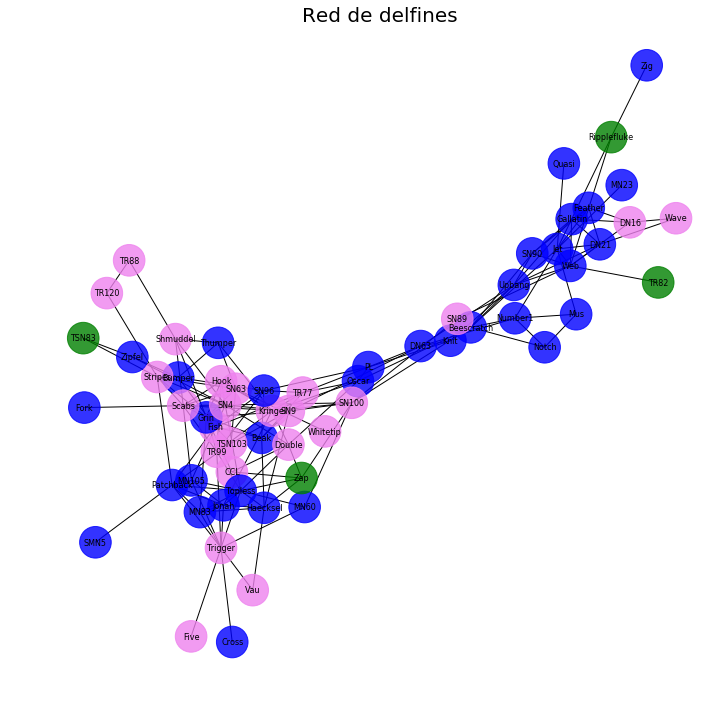

In [4]:
#------------------------------------------------------------------------------------------------------
#Grafico Original
#------------------------------------------------------------------------------------------------------
width=12
height=12
fig=plt.figure(figsize=(width, height))
fig.patch.set_facecolor('white')
pos = nx.spring_layout(mydolphins)

#Nodos
nx.draw_networkx_nodes(mydolphins,
                       pos,
                       nodelist=mydolphins.nodes(),
                       node_color=["blue" if g=="m" else "violet" if g=="f" else "green" for g in nx.get_node_attributes(mydolphins, "gender").values()],
                       with_labels=True,node_size=1000,alpha=0.8)

#Enlaces
nx.draw_networkx_edges(mydolphins,pos,width=1.0,alpha=1)

#Etiquetas
nx.draw_networkx_labels(mydolphins,pos,font_size=8)
plt.title('Red de delfines',fontsize=20)
plt.axis('off')
plt.show()

In [5]:
#------------------------------------------------------------------------------------------------------
#Metodo: Louvain
#------------------------------------------------------------------------------------------------------
G=mydolphins.copy()
part = community.best_partition(G) # diccionario con nodo - comunidad (nro)

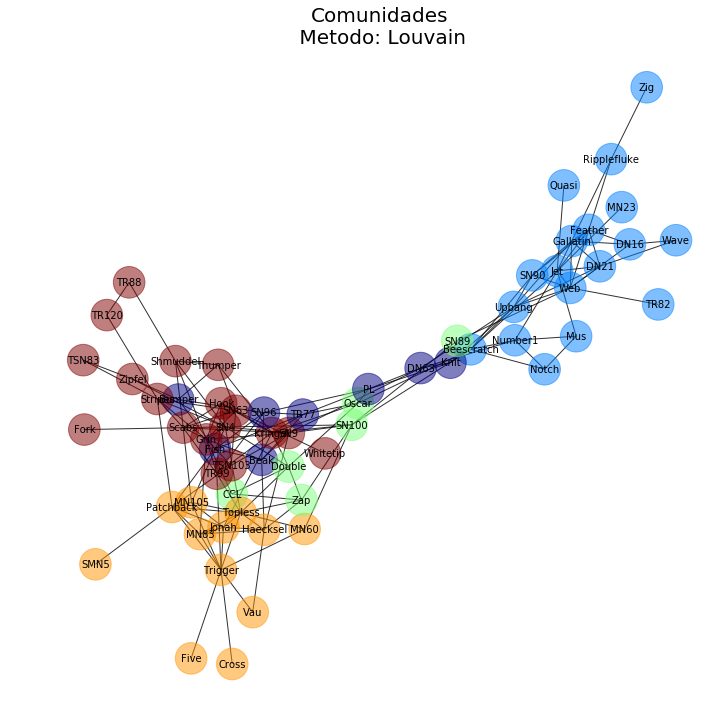

In [6]:
#------------------------------------------------------------------------------------------------------
#Visualizo comunidades
#------------------------------------------------------------------------------------------------------
comunidades=list(part.values())#lista de comunidades desordenada y repetidas
L=len(comunidades)#cantidad de nodos
a=np.unique(comunidades)
l=len(a) #cantidad de comunidades
delfines = G.nodes()

colores_com = np.linspace(0,1,l) # quiero n colores
colores = [ cm.jet(x) for x in colores_com ] # transformo en colores del colormap que quiera

width=12
height=12
fig=plt.figure(figsize=(width, height))
fig.patch.set_facecolor('white')

nx.draw_networkx_nodes(G,pos,
                       node_color = [colores[g] for g in part.values()],
                       node_size=1000,
                       alpha=0.5)

nx.draw_networkx_edges(G,pos,width=1.0,
                       alpha=0.8)
#Etiquetas
nx.draw_networkx_labels(mydolphins,pos,font_size=10)
plt.title('Comunidades\n Metodo: Louvain',fontsize=20)
plt.axis('off')

plt.show()

In [7]:
#------------------------------------------------------------------------------------------------------
#Caracterización de Modularidad y Silhouette
#------------------------------------------------------------------------------------------------------
#Modularidad Total:
#-------------------------------------------------------------
#Matriz de Adyacencias Aij:
A = np.array(nx.to_numpy_matrix(G,nodelist=delfines))
N=G.number_of_nodes()
m=G.number_of_edges()
grado = dict(G.degree())

#Matriz de variable categorica comunidad: Cij=delta(ci,cj)
C=np.zeros(np.shape(A))
for i,com_i in enumerate(comunidades):
    for j,com_j in enumerate(comunidades):
        if (com_i==com_j):
            C[i,j]=1
            
#Calculo de la modularidad
#Q/Qmax=(S1-S2)*(1/2m)
#S1=Suma en nodos (Aij*Cij)
#S2=Suma en nodos(kikj*Cij/2m)
S1=0
S2=0
for ni, delfin_i in enumerate(delfines):
    for nj, delfin_j in enumerate(delfines):  
        S1=S1+A[ni,nj]*C[ni,nj]
        S2=S2+grado[delfin_i]*grado[delfin_j]*C[ni,nj]
S2=S2/(2*m)
mod=(S1-S2)/(2*m)

print('Modularidad Total = {0:.3f}'.format(mod))

#------------------------------------------------------------------------------------------------------
#Modularidad de cada Partición:
#-------------------------------------------------------------

#Calculando la modularidad de cada comunidad:
modularidades=[]

for com in a:
    S1=0
    S2=0
    for ni, delfin_i in enumerate(delfines):
        for nj, delfin_j in enumerate(delfines):
            if com == list(part.values())[ni]:
                S1=S1+A[ni,nj]*C[ni,nj]
                S2=S2+grado[delfin_i]*grado[delfin_j]*C[ni,nj]

    S2=S2/(2*m)
    mod=(S1-S2)/(2*m)
    modularidades.append(float(mod))

ls= [round(x, 3) for x in modularidades]

print('Modularidades por comunidad = ')
print(ls)

#Checkeo 
#print('Modularidad = {0:.3f}'.format(np.sum(modularidades)))

Modularidad Total = 0.519
Modularidades por comunidad = 
[0.065, 0.171, 0.03, 0.11, 0.142]


Silhouette S[i]=
[('Beak', 0.3571428571428572), ('Beescratch', -0.05714285714285717), ('Bumper', 0.045454545454545414), ('CCL', 0.1818181818181818), ('Cross', -0.04347826086956529), ('DN16', -0.1315789473684211), ('DN21', 0.09090909090909083), ('DN63', 0.045454545454545414), ('Double', 0.27272727272727276), ('Feather', 0.15151515151515146), ('Fish', 0.1818181818181818), ('Five', -0.04347826086956529), ('Fork', -0.1951219512195122), ('Gallatin', 0.1818181818181818), ('Grin', 0.24242424242424243), ('Haecksel', 0.045454545454545414), ('Hook', 0.06060606060606052), ('Jet', 0.2121212121212121), ('Jonah', 0.27272727272727276), ('Knit', -0.02222222222222226), ('Kringel', -0.22857142857142856), ('MN105', 0.0), ('MN23', -0.3571428571428572), ('MN60', -0.14285714285714285), ('MN83', 0.055555555555555504), ('Mus', -0.30769230769230765), ('Notch', -0.43749999999999994), ('Number1', -0.25), ('Oscar', -0.10000000000000003), ('Patchback', 0.16666666666666666), ('PL', 0.11111111111111116), ('Quasi', -

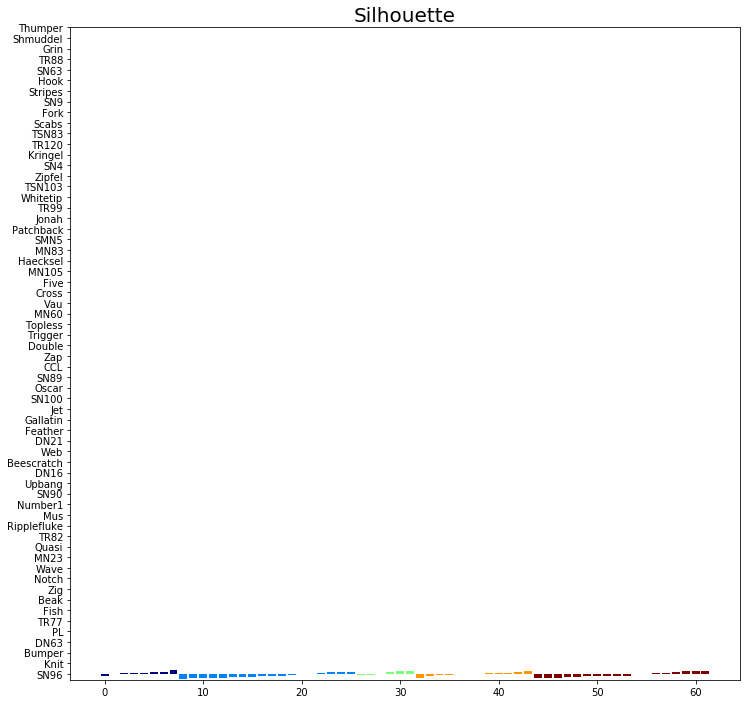

In [111]:
#------------------------------------------------------------------------------------------------------
#Silhouette:
#-------------------------------------------------------------
#distancia promedio de un nodo a todos los de su comunidad
#distancia se podria medir como el numero de links en el camino mas corto para llegar a otro.
#Ej: distancia entre 'Jet' y 'Trigger' = len(nx.shortest_path(mydolphins,'Jet','Trigger')) - 1

#Calculo a[i]
a=[] #contendra para cada nodo en delfines la distancia promedio a nodos de su misma comunidad
for i,com_i in enumerate(comunidades):
    distancias=[]
    for j,com_j in enumerate(comunidades):
        if (com_i==com_j):
            distancias.append(len(nx.shortest_path(G,list(part.keys())[i],list(part.keys())[j]))-1)         
    
    promedio=np.mean(distancias)
    a.append(promedio)

#Calculo b[i]
b=[] #contendria para cada delfin la distancia promedio a nodos de otras comunidades, devuelvo el promedio minimo
distancias_prom=[] #es la lista q tiene mis distancias minimas 
b_com_dist = [] #es un tuple que tiene comunidad y distancia promedio del nodo i

for i,com_i in enumerate(comunidades): #recorro las comunidades, donde cada lugar representa un delfin
    for c in a: #recorro las comunidades
        distancias=[] #armo una lista que me indique las distancias por comunidad
        for j,com_j in enumerate(comunidades): #recorro nuevamente para comparar
            if (com_i!=com_j and com_j==c): #Busco de forma ordenada los delfines
                #distancias.append((c, com_i, com_j,len(nx.shortest_path(G,list(part.keys())[i],list(part.keys())[j]))-1))
                distancias.append(len(nx.shortest_path(G,list(part.keys())[i],list(part.keys())[j]))-1)
        if len(distancias)!=0:
            distancias_prom.append(np.mean(distancias))
        
    b.append(min(distancias_prom))
    

#Calculo Silhouette:
S=[]
for i,delfin in enumerate(delfines):
    s=(b[i]-a[i])/(max(b[i],a[i]))
    S.append(s)
    #guardo la propiedad silhouette en el grafo:
    G.node[delfin]['silhouette']=s
print('Silhouette S[i]=')
print (G.nodes.data('silhouette'))


#Grafico Silhouette:
width=12
height=12
plt.figure(figsize=(width, height))
delfines=np.sort(delfines)
y = []
yTicks = []
contador=-1
dtype = [('name', 'S21'),('silhouette', float)]
a=np.unique(comunidades)
for c in a:
    delf_S=[] #lista con pares de [delfin,silouette]
    for i,com_i in enumerate(comunidades): 
        if com_i==c:
            delf_S.append((str(list(part.keys())[i]),G.nodes[list(part.keys())[i]]['silhouette']))        
    delf_S=np.array(delf_S,dtype=dtype)
    delf_S=np.sort(delf_S,order='silhouette') #lo ordeno segun la propiedad silhouette
    delf_S=list(delf_S)
    
    for j,d in enumerate(delf_S):
        contador=contador+1
        delfin=str(delf_S[j][0],'utf-8')
        silhouette_value=delf_S[j][1]
        plt.bar(contador,silhouette_value, color = colores[c])#grafico una barra
        y.append(contador)
        yTicks.append(delfin)
plt.yticks(y, yTicks)
plt.yticks(range(len(delfines)),yTicks)
plt.title('Silhouette',fontsize=20)
plt.show()

In [97]:
delf_S

[]